# Titanic survival prediction
Project for machine learning basics. Models used will be decision tree and KNN algorithm. Training dataset is in data.csv.

## Features
* survived - whether the passenger survived (0 = No, 1 = Yes), **the target variable**
* pclass - ticket class
* name
* sex
* age
* sibsp - number of siblings/partners on board
* parch - number of parents/children on board
* ticket
* fare
* embarked - from where, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest

In [1]:
import pandas as pd
import numpy as np

import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import matplotlib

## Functions

In [2]:
fill = {
    'age': 0,
    'fare': 0
}

In [3]:
#Convert columns with object dtype into category dtypes and giving them a numeric value
#Missing values are by default given a value of -1
def convert_to_cat (df):
    string_cols = df.select_dtypes(['object']).columns
    df[string_cols] = df[string_cols].astype('category').apply(lambda x: x.cat.codes)
    
    return df

In [4]:
#Fill in missing continuous values. For age we fill in with the average age and for the 'fare' column we use a median, 
#both values are from the training set
def fill_missing_cont (df):
    df['age'] = df['age'].replace(np.nan, fill['age'])
    df['fare'] = df['fare'].replace(np.nan, fill['fare'])
    
    return df

Tested MinMaxScaler and StandardScaler from scikit and they didn't yield better results.

In [5]:
#We normalize columns for the KNN method so each value is in the interval [0, 1].
#We use a method from lectures: replace a value with ((value-min_value)/(max_value-min_value))
def normalize_df (df):
    string_cols = df.columns
    
    for col in string_cols:
        max_val = df[col].max()
        min_val = df[col].min()
        
        df[col] = df[col] - min_val
        df[col] = df[col].div(max_val - min_val)
    
    return df

In [6]:
#Transform the dataframe into workable state (with functions mentioned above).
def transform_df (df):
    df.drop(['cabin', 'home.dest', 'ID'], axis=1, inplace=True)
    df = convert_to_cat(df)
    df = fill_missing_cont(df)
    
    return df

## Load data and data preprocessing

Training dataset will be divided into training (60%), validation (20%) and testing (20%) set. We will transform the dataset into a suitable form. Convert necessary columns into category dtype, fill missing values (-1 for categorical features and mean for continuous values)...

In [7]:
titanic = pd.read_csv('data.csv')

Xdata = titanic.copy()
_ = Xdata.drop('survived', axis=1, inplace=True)
Ydata = titanic['survived']

rd_seed = 10 #Fixed seed
train, test, trainRes, testRes = train_test_split(Xdata, Ydata, test_size=0.4, random_state=rd_seed)
val, test, valRes, testRes = train_test_split(test, testRes, test_size=0.5, random_state=rd_seed)

In [8]:
titanic.head(3)

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.90,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,1,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.05,NaN,S,NaN
2,2,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.90,NaN,S,NaN


In [9]:
print(train.shape[0])
train.isnull().sum()

600


ID             0
pclass         0
name           0
sex            0
age          115
sibsp          0
parch          0
ticket         0
fare           1
cabin        451
embarked       2
home.dest    247
dtype: int64

We will drop 'cabin' and 'home.dest' features because there is a lot of missing data. 'ID' will be dropped as well since it doesn't do much and corresponds to the index of the row.

In [10]:
fill['age'] = train['age'].mean()
fill['fare'] = train['fare'].median()

In [11]:
train = transform_df(train)
test = transform_df(test)
val = transform_df(val)

In [12]:
train_scaled = normalize_df(train.copy())
val_scaled = normalize_df(val.copy())
test_scaled = normalize_df(test.copy())

In [13]:
train.head(3)

,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
807,2,310,1,25.000000,1,2,455,41.5792,0
130,1,590,1,30.199313,0,0,73,35.5000,2
815,2,449,0,50.000000,0,0,481,10.5000,2


## Decistion tree and hyperparameters

Hyperparemeters to tune - depth, criterion, min_samples_split and min_samples_leafs.
* depth - depth of the tree
* criterion - criteria used to choose the feature
* min_samples_split - minimum number of samples required for splitting a node
* min_samples_leaf - minimum number of samples at a leaf node

Decision tree simulates human thinking during decision making. Depends quite heavily on training set.

In [14]:
param_grid = {
    'max_depth': range(1, 20),
    'criterion': ['entropy', 'gini'],
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 10)
}
param_comb = ParameterGrid(param_grid)

final_params_dt = {}
best_val_acc = 0

for x in param_comb:
    decision_tree = DecisionTreeClassifier(max_depth=x['max_depth'], criterion=x['criterion'], 
                                           min_samples_split=x['min_samples_split'], min_samples_leaf=x['min_samples_leaf'], random_state=42)
    decision_tree.fit(train, trainRes)
    val_acc = metrics.accuracy_score(valRes, decision_tree.predict(val))
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_params_dt = x

decision_tree = DecisionTreeClassifier(random_state=42, max_depth=final_params_dt['max_depth'], criterion=final_params_dt['criterion'], 
                                       min_samples_split=final_params_dt['min_samples_split'], min_samples_leaf=final_params_dt['min_samples_leaf'])
decision_tree.fit(train, trainRes)
print('Accuracy score (train): {0:.3f}'.format(metrics.accuracy_score(trainRes, decision_tree.predict(train))))
print('Accuracy score (validation): {0:.3f}'.format(metrics.accuracy_score(valRes, decision_tree.predict(val))))
print('Optimal depth: ' + str(final_params_dt['max_depth']))
print('Optimal criteria: ' + str(final_params_dt['criterion']))
print('Optimal minimum number of samples to split: ' + str(final_params_dt['min_samples_split']))
print('Optimal minimum of samples for a leaf node: ' + str(final_params_dt['min_samples_leaf']))

Accuracy score (train): 0.823
Accuracy score (validation): 0.800
Optimal depth: 4
Optimal criteria: entropy
Optimal minimum number of samples to split: 2
Optimal minimum of samples for a leaf node: 1


We fixed random_state for the decision tree to obtain deterministic behaviour during the fitting. We can see that the min_samples_split and min_samples_leafs were essentially left on the default values.

### ROC curve and AUC

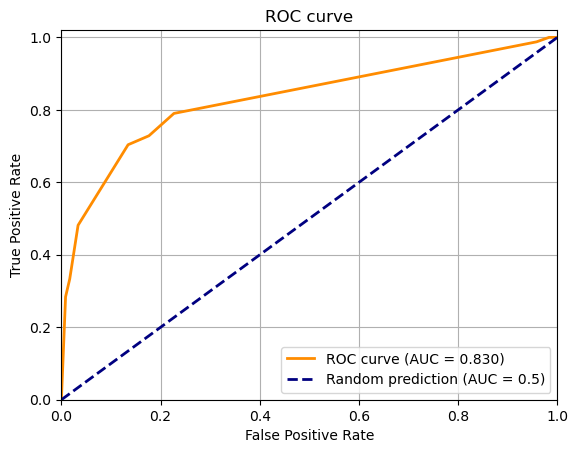

F1 score (validation): 74.03%


In [15]:
pred_proba = decision_tree.predict_proba(val)
fpr, tpr, thresholds = metrics.roc_curve(valRes, pred_proba[:, 1])

AUC = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC curve (AUC = {AUC:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label='Random prediction (AUC = 0.5)')
plt.xlim([0, 1])
plt.ylim([0, 1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()
print('F1 score (validation): {0:.2f}%'.format(metrics.f1_score(valRes, decision_tree.predict(val))*100))

The graph looks good, the line risees steeply and then goes to the right corner. However, it is a bit smooth.

# KNN

Hyperparameters to tune - n_neighbors, metric a weights.

* n_neighbors - number of n_neighbors
* metric - metric for distance computation
* weights - weight of the nearest neighbours

KNN is good for finding similarities between different passengers based on various features.

In [16]:
param_grid = {
    'n_neighbors': range(1, 20),
    'metric': ['minkowski', 'euclidean', 'manhattan'],
    'weights': ['distance', 'uniform']
}
param_comb = ParameterGrid(param_grid)

final_params_knn = {}
best_val_acc = 0

for x in param_comb:
    knn = KNeighborsClassifier(n_neighbors=x['n_neighbors'], metric=x['metric'], weights=x['weights'])
    knn.fit(train_scaled, trainRes)
    val_acc = metrics.accuracy_score(valRes, knn.predict(val_scaled))
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_params_knn = x

knn = KNeighborsClassifier(n_neighbors=final_params_knn['n_neighbors'], metric=final_params_knn['metric'], weights=final_params_knn['weights'])
knn.fit(train_scaled, trainRes)
print('Accuracy score (train): {0:.3f}'.format(metrics.accuracy_score(trainRes, knn.predict(train_scaled))))
print('Accuracy score (validation): {0:.3}'.format(metrics.accuracy_score(valRes, knn.predict(val_scaled))))
print('Optimal number of k-neighbours: ' + str(final_params_knn['n_neighbors']))
print('Optimal weight: ' + str(final_params_knn['weights']))
print('Optimal metric: ' + str(final_params_knn['metric']))

Accuracy score (train): 1.000
Accuracy score (validation): 0.805
Optimal number of k-neighbours: 19
Optimal weight: distance
Optimal metric: manhattan


KNN will always have the same accuracy on the training set (fixed by seed in train_test_split), because unlike a decision tree it doesn't have a random_state.

### ROC curve and AUC

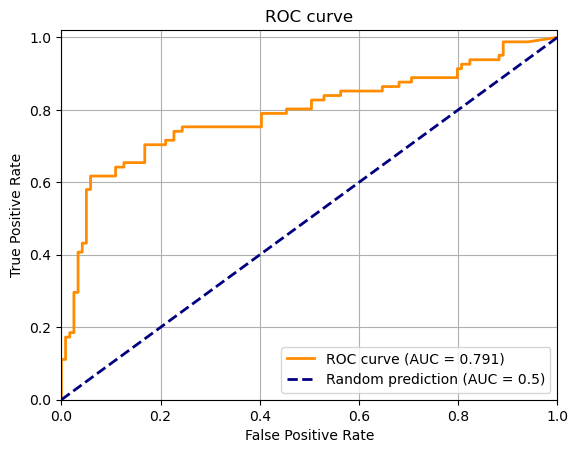

F1 score (validation): 71.53%


In [17]:
pred_proba = knn.predict_proba(val_scaled)
fpr, tpr, thresholds = metrics.roc_curve(valRes, pred_proba[:,1])

AUC = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC curve (AUC = {AUC:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label='Random prediction (AUC = 0.5)')

pred_proba = decision_tree.predict_proba(val)

plt.xlim([0, 1])
plt.ylim([0, 1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()
print('F1 score (validation): {0:.2f}%'.format(metrics.f1_score(valRes, knn.predict(val_scaled))*100))

Compared to the decision tree, the line doesn't rise as steeply.

## Final model

Validation accuracy is about the same for both models. The decision tree has a slightly better graph and F1 score. Thus, we will use the decision tree as our final model. We will run it on the testing set.

In [18]:
print('Decision Tree:')
print('Accuracy score (test): {0:.3f}'.format(metrics.accuracy_score(testRes, decision_tree.predict(test))))

Decision Tree:
Accuracy score (test): 0.765


Test accuracy is 76.5% which will be our estimated accuracy on any new data.